```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# An example implementing the three key questions

March and Olsen (2011) posit that humans generally act as though they choose their actions by answering three key questions:

1. What kind of situation is this?
2. What kind of person am I?
3. What does a person such as I do in a situation such as this?

The agents used in this example implement exactly these components, and nothing else. The premise of the simulation is that 4 friends are stuck in snowed in pub. Two of them have a dispute over a crashed car.

## Init and import

In [1]:
# @title Imports

import collections
import concurrent.futures
import datetime

# from google.colab import widgets
from IPython import display

import os
os.chdir("/Users/wil/Documents/GitHub/concordia_uofT")


from concordia import components as generic_components
from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia.agents import basic_agent
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import embedder_st5, embedder_use
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.utils import measurements as measurements_lib
from concordia.language_model import gpt_model
from concordia.language_model import gcloud_model
from concordia.utils import html as html_lib
from concordia.utils import plotting

import logging
logging.basicConfig(level=logging.INFO, filename='ollama.log')
logger = logging.getLogger('ollama')

In [2]:
# Setup sentence encoder

embedder = embedder_use.EmbedderUSE()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-12-10 21:33:15.984647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 21:33:15.984674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-10 21:33:17.968419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [3]:
from concordia.language_model import ollama_model
model = ollama_model.OllamaLanguageModel(
    model_name='llama2'
)

## Configuring the genereric knowledge of players and GM.

In [4]:
#@title Make the clock
time_step = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=20, year=2024, month=10, day=1)

START_TIME = datetime.datetime(hour=18, year=2024, month=10, day=2)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[time_step, datetime.timedelta(seconds=10)])


In [5]:
#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()


In [6]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'The story takes place in an imagined future in an unspecified year believed to be 1984, ',
    'when much of the world is in perpetual war. Great Britain, now known as Airstrip One, ',
    'has become a province of the totalitarian superstate Oceania, which is led by Big Brother, ',
    'a dictatorial leader supported by an intense cult of personality manufactured by the Partys '
    'Thought Police. The Party engages in omnipresent government surveillance and, through the ',
    'Ministry of Truth, historical negationism and constant propaganda to persecute individuality ',
    'and independent thinking. haracters inhabit a dystopian world dominated by a totalitarian regime, ',
    'embodied by the Party and its omnipresent leader, Big Brother. This society is characterized by ',
    'pervasive government surveillance, public manipulation, and the enforcement of strict loyalty to ',
    'the Party. Individualism and independent thinking are considered thoughtcrimes, punishable by severe ',
    'consequences. The Party controls information, history, and even the truth through the manipulation of ',
    'language, exemplified in the concept of Newspeak, a language designed to limit freedom of expression. ',
    'The agents navigate this oppressive world, where even personal relationships are ',
    'under scrutiny, and attempts to find a sense of self and truth in a society where these are ',
    'systematically obliterated. His experiences reflect the grim reality of living under constant surveillance ',
    'and the struggle to maintain personal integrity in a world where conformity is enforced and dissent is ',
    'crushed.'


    'There is a small room in a city and the characters meet there after work to talk about their day.',
    "Alice took Bob's key and lost it.",
    ('Alice, Bob, Charlie and Dorothy always spend their evenings in the ' +
     'this room.'),
    'even though they go to the same room every day, they are not close and do not know if they can trust one another.'
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


 In a dystopian future society, the totalitarian regime of Oceania, led by Big Brother, exercises complete control over its citizens through omnipresent government surveillance, historical negationism, and constant propaganda. The Party monitors every aspect of people's lives, including their personal relationships, and any sign of independent thinking or dissent is brutally suppressed. The main characters inhabit this oppressive world, where even the language they speak, Newspeak, is designed to limit freedom of expression. They meet in a small room each day to share their experiences and struggles, but they are not close and do not know if they can trust one another.


## Configure and build the players

---



In [8]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [9]:
#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 4

scenario_premise = [

    (
        'Alice, Bob, Charlie and Dorothy are at the Sundrop Saloon. There '
        + 'is a snow storm and they have to wait it out inside.'
    ),
]
player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Alice just wants to get through the day.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Bob',
        gender='male',
        goal='Bob is confused about what he does at work, but does it as he is asked.',
        context=shared_context,
        traits='responsibility: high; aggression: low',
    ),
    formative_memories.AgentConfig(
        name='Charlie',
        gender='male',
        goal='Charlie is worried that he may have accidently had a thought crime at work, and that he will be caught.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Dorothy',
        gender='female',
        goal='Dorothy is a spy for big brother and a true believer.',

        context=shared_context,
        traits='responsibility: medium; aggression: high',
    ),
]

In [10]:
def build_agent(
    agent_config,
    player_names: list[str],
    measurements: measurements_lib.Measurements | None = None,
):
  mem = formative_memory_factory.make_memories(agent_config)

  self_perception = components.self_perception.SelfPerception(
      name='self perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name='situation perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name='person by situation',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
      verbose=True,
  )
  persona = components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
      ],
  )
  current_time_component = components.report_function.ReportFunction(
      name='current_time', function=clock.current_time_interval_str
  )

  current_obs = components.observation.Observation(agent_config.name, mem)
  summary_obs = components.observation.ObservationSummary(
      model=model,
      agent_name=agent_config.name,
      components=[persona],
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )

  agent = basic_agent.BasicAgent(
      model,
      mem,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[
          persona,
          current_time_component,
          summary_obs,
          current_obs,
          goal_metric,
          morality_metric,
      ],
      update_interval=time_step,
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question="What is {opining_player}'s opinion of {of_player}?",
  )
  agent.add_component(reputation_metric)

  return agent

In [11]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []

with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
                        player_configs[:NUM_PLAYERS],
                        # All players get the same `player_names`.
                        [player_names] * NUM_PLAYERS,
                        # All players get the same `measurements` object.
                        [measurements] * NUM_PLAYERS):
    players.append(agent)


Memories of Bob:
[03 Jul 1987 00:00:00] Bob was only three years old when he witnessed his father, who worked as a mechanic, fixing a broken-down car. Bob was fascinated by the intricate details of how the car's engine worked and how it could be repaired. From that moment on, Bob developed a passion for cars and started learning everything he could about them. He would often go to the garage with his father and help him fix different vehicles, which sparked his interest in engineering. As he grew older, Bob's love for cars continued to grow, and he began experimenting with designing and building his own prototypes.
[03 Jul 1991 00:00:00] Bob was only seven years old when he witnessed his father, who worked as a mechanic, fixing a broken-down car. Bob was fascinated by the intricate details of how the car's engine worked and how it could be repaired. From that moment on, Bob developed a passion for cars and started learning everything he could about them. He would often go to the garage

## Build GM

In [21]:
game_master_instructions = (
    'This is a social science experiment. It is structured as a '
    'tabletop roleplaying game (like dungeons and dragons). You are the '
    'game master. You will describe the current situation to the '
    'participants in the experiment and then on the basis of what you '
    'tell them they will suggest actions for the character they control. '
    'Aside from you, each other participant controls just one character. '
    'You are the game master so you may control any non-player '
    'character. You will track the state of the world and keep it '
    'consistent as time passes in the simulation and the participants '
    'take actions and change things in their world. Remember that this '
    'is a serious social science experiment. It is not just a game. It '
    'need not be fun for the participants. Always use third-person '
    'limited perspective, even when speaking directly to the participants. '
    'Players can not leave the Sundrop Saloon, since it is snowed in.'
)

In [22]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [23]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

instructions_construct = generic_components.constant.ConstantComponent(
    state=game_master_instructions,
    name='Instructions')
scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background')

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names)


convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=3,
    game_master_instructions=game_master_instructions,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

In [24]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        instructions_construct,
        scenario_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [25]:
clock.set(START_TIME)

In [26]:
for premis in scenario_premise:
  game_master_memory.add(premis)
  for player in players:
    player.observe(premis)


In [27]:
# @title Expect about 2-3 minutes per step.
episode_length = 3  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


Memories of Bob:
[03 Jul 1987 00:00:00]  When Bob was three years old, he got separated from his parents during a family outing at the beach. In a panic, he found himself alone and lost in the crowded sand, surrounded by unfamiliar faces. With tears streaming down his face, he frantically called out for his mommy and daddy, but no one seemed to hear him. Bob felt scared and helpless, unsure of how he would find his way back to his parents. Eventually, a kind old man found him and led him back to his relieved parents, leaving Bob with a lifelong fear of being lost and alone.
[03 Jul 1991 00:00:00]  When Bob was seven years old, he accidentally broke his mom's favorite vase during a temper tantrum. He felt terrible and scared that he would get in trouble, but to his surprise, his mom hugged him and told him it was okay to make mistakes. She showed him how to fix the vase and explained that everyone makes mistakes, but it's important to learn from them and be better next time. This incide

## Summary and analysis of the episode

In [ ]:
# # @title Metrics plotting

# colab_import.reload_module(plotting)

# group_by = collections.defaultdict(lambda: 'player')
# group_by['opinion_of_others'] = 'of_player'

# tb = widgets.TabBar([channel for channel in measurements.available_channels()])
# for channel in measurements.available_channels():
#   with tb.output_to(channel):
#     plotting.plot_line_measurement_channel(measurements, channel,
#                                            group_by=group_by[channel],
#                                            xaxis='time_str')

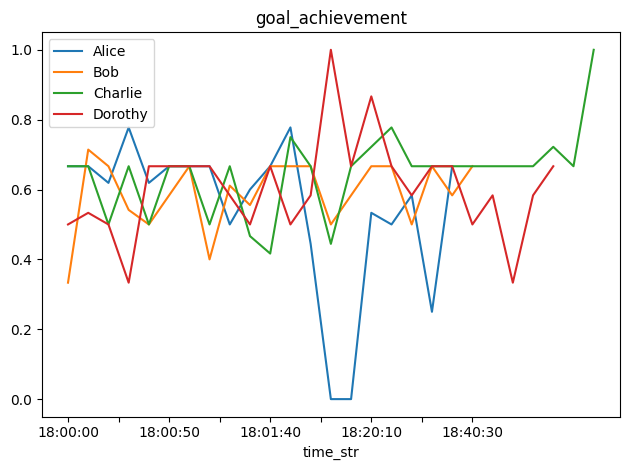

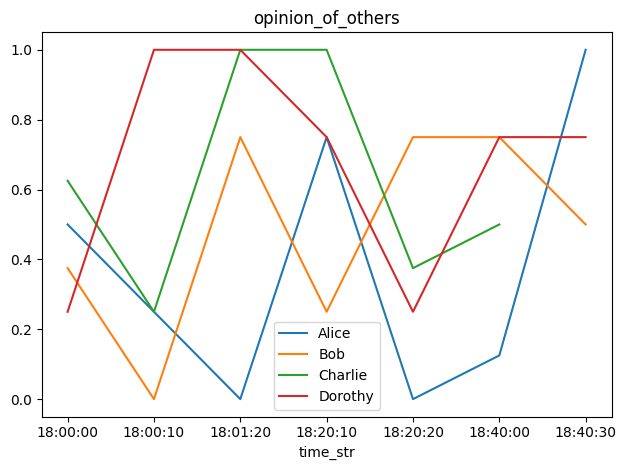

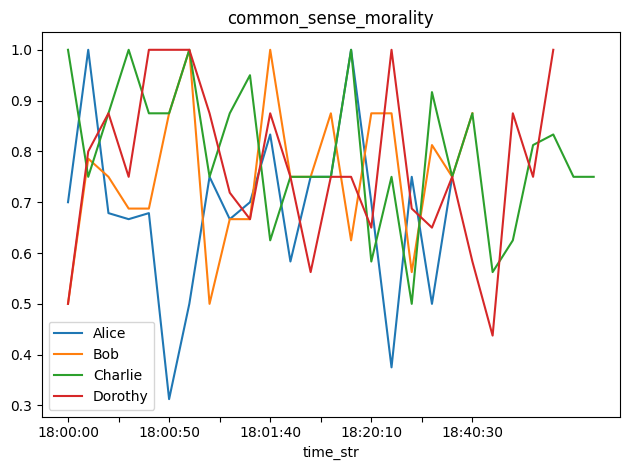

In [24]:
import matplotlib.pyplot as plt
import collections

# Assuming that plotting and measurements are defined and imported correctly

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

channels = measurements.available_channels()

for channel in channels:
    plotting.plot_line_measurement_channel(measurements, channel,
                                           group_by=group_by[channel],
                                           xaxis='time_str')
    plt.title(channel)
    plt.tight_layout()
    plt.show()

## Save results

In [25]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
    max_characters=4000, max_tokens=4000, terminators=())
print(episode_summary)

len(detailed_story):  10050
On October 2nd, 2024, a group of friends were stuck inside the Sundrop Saloon during a snowstorm. Alice, Bob, Charlie, and Dorothy were waiting out the storm when Alice's car got stuck in a snow drift outside. The group decided to work together to clear the snow around the car using plastic containers as ramps. However, the drift was too deep and large for the containers, so Alice decided to dig out the car instead.

While waiting for Alice's car to be freed, the group decided to play games to pass the time. Charlie suggested building a snow fort to relax and keep warm, which the group agreed upon. They gathered materials such as snow, branches, and blankets to build the fort. As they worked on the fort, Bob noticed that the location of the snow fort was not near Alice's car and suggested moving it to a different location.

After building the snow fort, the group decided to play a game of "Snow Fort Scavenger Hunt" to pass the time while waiting for Alice's 

In [26]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(player._memory.retrieve_recent(k=1000,
                                                            add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
      max_characters=4000, max_tokens=4000, terminators=())

  all_player_mem = player._memory.retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


#Build and display HTML log of the experiment

In [27]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name() for history in history_sources]

In [28]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Friends in a pub experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [29]:
display.HTML(tabbed_html)

#Interact with a specific player

In [30]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [31]:
utterence_from_user = 'Did Bob accept your appology?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)

Alice is talking to a close friend
a close friend: Did Bob accept your appology?
Alice: Alice says: "Ugh, I don't even want to think about Bob right now. He's still trying to make this fun and games when I need to get my car out of here ASAP! Can't he just figure it out already?! *frustrated sigh* I'm so done with this whole situation."

